# Nigerian Music scraped from Spotify - an analysis

In [104]:
pip install seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Start where we finished in the last lesson, with data imported and filtered.

In [105]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv("../../data/nigerian-songs.csv")
df.head()

,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Sparky,Mandy & The Jungle,Cruel Santino,alternative r&b,2019,144000,48,0.666,0.8510,0.420,0.534000,0.1100,-6.699,0.0829,133.015,5
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
2,LITT!,LITT!,AYLØ,indie r&b,2018,207758,40,0.836,0.2720,0.564,0.000537,0.1100,-7.127,0.0424,130.005,4
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4


We will focus only on 3 genres. Maybe we can get 3 clusters built!

Text(0.5, 1.0, 'Top genres')

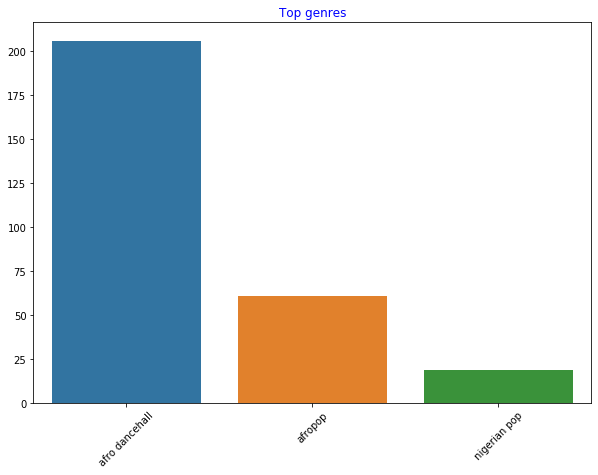

In [106]:
df = df[(df['artist_top_genre'] == 'afro dancehall') | (df['artist_top_genre'] == 'afropop') | (df['artist_top_genre'] == 'nigerian pop')]
df = df[(df['popularity'] > 0)]
top = df['artist_top_genre'].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=top.index,y=top.values)
plt.xticks(rotation=45)
plt.title('Top genres',color = 'blue')

In [107]:
df.head()

,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4
5,Kasala,Pioneers,DRB Lasgidi,nigerian pop,2020,184800,26,0.803,0.1270,0.525,0.000007,0.1290,-10.034,0.1970,100.103,4
6,Pull Up,Everything Pretty,prettyboydo,nigerian pop,2018,202648,29,0.818,0.4520,0.587,0.004490,0.5900,-9.840,0.1990,95.842,4


In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# X = df.loc[:, ('danceability','energy')]







In [110]:
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn import datasets

X = df[['danceability','acousticness']].values
y = df['energy'].values

# X = scaler.fit_transform(X)

# step size in the mesh
h = .02

rng = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_30 = np.copy(y)
y_30[y_rand < 0.3] = -1  # set random samples to be unlabeled
y_50 = np.copy(y)
y_50[y_rand < 0.5] = -1
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30 = (LabelSpreading().fit(X, y_30), y_30, 'Label Spreading 30% data')
ls50 = (LabelSpreading().fit(X, y_50), y_50, 'Label Spreading 50% data')
ls100 = (LabelSpreading().fit(X, y), y, 'Label Spreading 100% data')

# the base classifier for self-training is identical to the SVC
base_classifier = SVC(kernel='rbf', gamma=.5, probability=True)
st30 = (SelfTrainingClassifier(base_classifier).fit(X, y_30),
        y_30, 'Self-training 30% data')
st50 = (SelfTrainingClassifier(base_classifier).fit(X, y_50),
        y_50, 'Self-training 50% data')

rbf_svc = (SVC(kernel='rbf', gamma=.5).fit(X, y), y, 'SVC with rbf kernel')

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}

classifiers = (ls30, st30, ls50, st50, ls100, rbf_svc)
for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='black')

    plt.title(title)

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

ValueError: Unknown label type: 'continuous'